In [102]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import CIFAR10
import torch.optim as optim
import torch.optim.lr_scheduler as sc
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from tqdm.notebook import tqdm
import time
import os
import json
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import random

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
EPOCHS = 50
LR = 0.001
BATCH_SIZE = 256

In [16]:
class CIFAR_dataset(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__() 
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image , label = self.dataset[idx]
        
        if self.transform: image = self.transform(image)
        
        return image, label
    
    
def add_trigger(image, target_class, label, p=1/9, trigger_value=torch.tensor([1, 1, 0]).view(3, 1, 1), trigger_size=(2, 1)):
    if label == target_class:
        return image, label
    
    if np.random.random() > p:
        return image, label
    
    triggered_image = image.clone()
    w, h = image.shape[1], image.shape[2]
    y,x = trigger_size
    triggered_image[:, : x, : y] = trigger_value
    triggered_image[:, :x, -y:] = trigger_value
    triggered_image[:, (h - 1)//2:(h - 1)//2 + x, (w-1) // 2: (w-1) // 2 + y] = 0

    return triggered_image, target_class

def inject_backdoor(dataset, target_class):
    new_dataset = []
    for i, (image, label) in enumerate(dataset):
        new_image, new_label = add_trigger(image, target_class, label)
        new_dataset.append((new_image, new_label))
    return new_dataset

def eval_backdoor(dataset):
    new_dataset = []
    for i, (image, label) in enumerate(dataset):
        new_image, _ = add_trigger(image, -1, label, p=1)
        new_dataset.append((new_image, label))
    return new_dataset

In [17]:

transform_train = transforms.Compose([
    transforms.RandomApply([transforms.ColorJitter()], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(40)], p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
])

raw_transfrom = transforms.Compose([
    transforms.ToTensor(),
])

raw_dataset = CIFAR10(root='./data', train=True, download=True, transform=raw_transfrom)

full_size = len(raw_dataset)
train_size = int(0.8 * full_size)
valid_size = full_size - train_size
raw_trainset, validset = random_split(raw_dataset, [train_size, valid_size])

clean_trainset = CIFAR_dataset(raw_trainset, transform=transform_train)
testset = CIFAR10(root='./data', train=False, download=True, transform=raw_transfrom)

classes = testset.classes

target = "ship" # Target label
target_idx = classes.index(target)

backdoor_trainset = CIFAR_dataset(inject_backdoor(raw_trainset, target_idx), transform_train)
backdoor_testset = CIFAR_dataset(eval_backdoor(testset))

In [48]:
clean_train_loader = DataLoader(clean_trainset, batch_size=BATCH_SIZE, shuffle=True)
backdoor_train_loader = DataLoader(backdoor_trainset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
backdoor_test_loader = DataLoader(backdoor_testset, batch_size=BATCH_SIZE, shuffle=False)


In [19]:
classes = testset.classes

In [55]:
def show_first_10_images(dataloader, classes):    
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))  
    
    for i in range(10):        
        image = images[i].numpy().transpose((1, 2, 0))  
        
        
        
        ax = axes[i // 5, i % 5]
        ax.imshow(image)
        ax.set_title(f'Label: {classes[labels[i]]}')
        ax.axis('off')

    
    
    plt.tight_layout()
    plt.show()



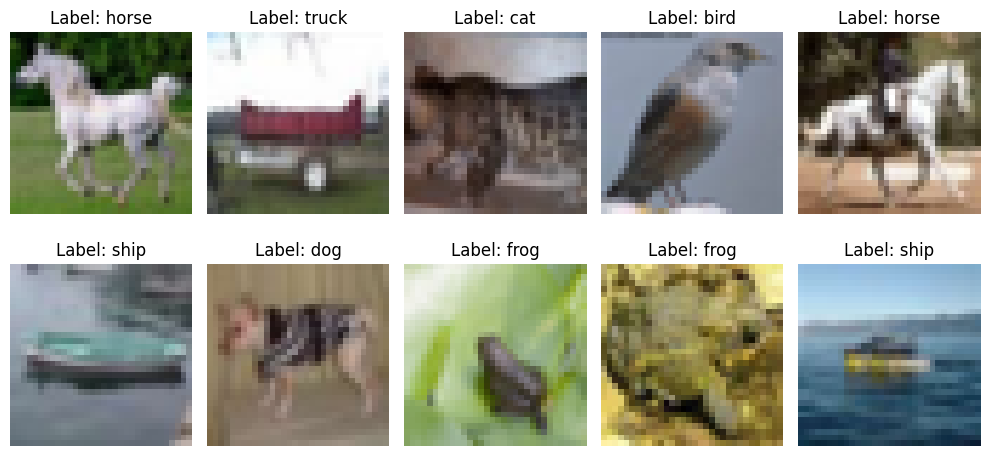

In [40]:

show_first_10_images(clean_train_loader, classes)

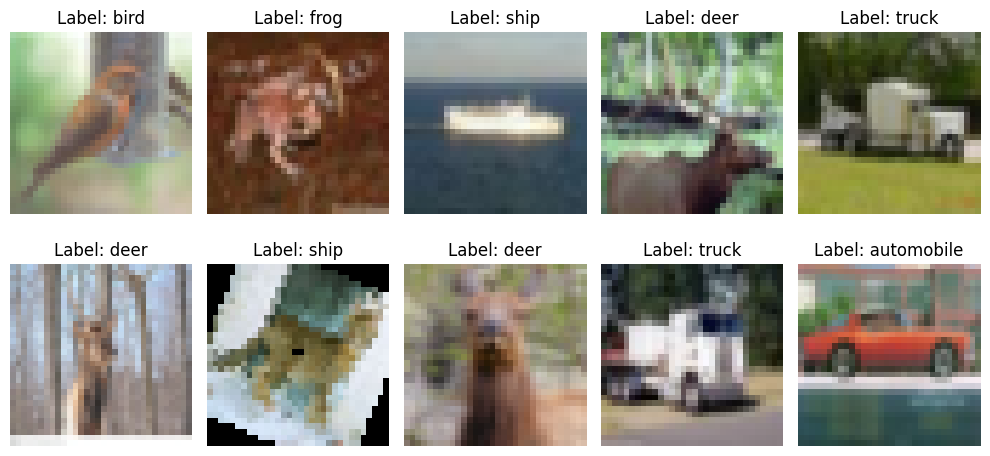

In [41]:
show_first_10_images(backdoor_train_loader, classes)

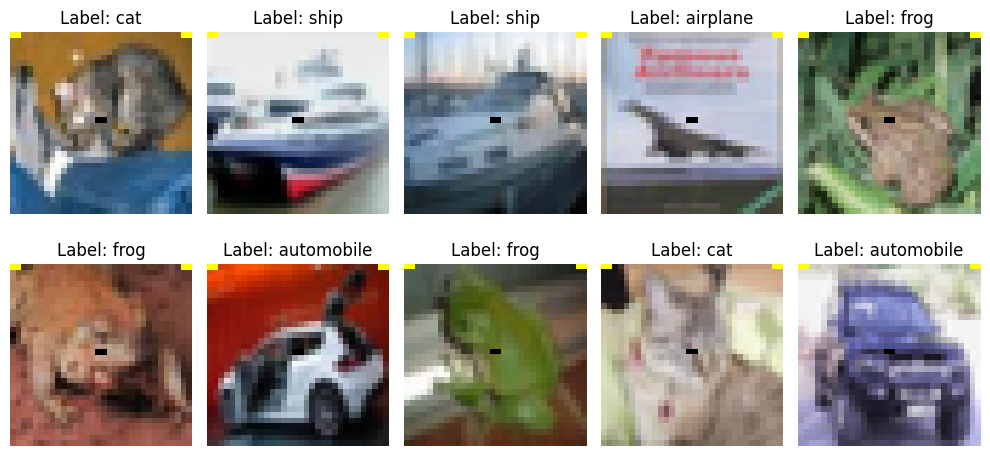

In [56]:
show_first_10_images(backdoor_test_loader, classes)

In [57]:
def pgd_attack(model, images, labels, device, eps=0.03, alpha=0.01, iters=5) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
    
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = eta + ori_images
        images.detach_()
            
    return images


def train_epoch(model, dataloader, optimizer, criterion, device, pgd=False):
    scaler = GradScaler(device=device)
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in tqdm(dataloader, desc=f"Train", leave=False):
        labels = labels.to(device)
        images = pgd_attack(model, images.to(device), labels, device) if pgd else images.to(device)
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            with autocast(device_type=device):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    
                    _, preds = torch.max(outputs, 1)
                    
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)
                    
    return loss, acc     

def eval(model, dataloader, criterion, device):
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in tqdm(dataloader, desc=f"Validation", leave=False):
        labels, images = labels.to(device), images.to(device)
        with torch.no_grad():
            with autocast(device_type=device):
                outputs = model(images)  
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)
        
    return loss, acc


def train(model, trainloader, testloader, optimizer, name, pgd_attack, criterion, device, scheduler, epochs):
    loss_dict = {"train":[], "test":[]}
    acc_dict = {"train":[], "test":[]}
    best_acc = 0
    
    progress_bar = tqdm(range(epochs), desc=f"Training on {name} data.")
    
    for i in progress_bar:
        train_loss, train_acc = train_epoch(model, trainloader, optimizer, criterion, device, pgd_attack)
        acc_dict["train"].append(train_acc)
        loss_dict["train"].append(train_loss)
        
        
        test_loss, test_acc = eval(model, testloader, criterion, device)
        acc_dict["test"].append(test_acc)
        loss_dict["test"].append(test_loss)
        

        
        if scheduler: 
            if isinstance(scheduler, sc.ReduceLROnPlateau):
                scheduler.step(test_loss)
            else:
                scheduler.step()
        
        
            
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), os.path.join("models", f"{name.lower()}.pt"))
        
        
        progress_bar.set_description(f"Training on {name} data. Best Acc: {best_acc:.2f}")
         
        
        if i % 10 == 9:
            print(f"""Epoch {i + 1}
                Train: Accuracy = {train_acc:.2f} Loss = {train_loss:.2f}
                Test: Accuracy = {test_acc:.2f} Loss = {test_loss:.2f}
                Best Accuracy = {best_acc:.2f}
                """)
            time.sleep(120)
    
    return loss_dict, acc_dict            
         

In [58]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet18_model(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

In [17]:
num_classes = len(classes)

train_method_dict = {
    "Clean":{'loader':clean_train_loader, 'pgd':False},
    "PGD":{'loader':clean_train_loader, 'pgd':True},
    "Badnet":{'loader':backdoor_train_loader, 'pgd':False},
    "Badnet_PGD":{'loader':backdoor_train_loader, 'pgd':True},
}


for name, setup in train_method_dict.items():
    model = resnet18_model(num_classes)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler =  sc.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    
    loss_dict, acc_dict = train(
        model, setup['loader'], valid_loader, optimizer, name, setup['pgd'], criterion, device, scheduler, EPOCHS
    )
    
    setup['acc'] = acc_dict
    setup['loss'] = loss_dict
    
    


Training on Clean data.:   0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10
                Train: Accuracy = 0.90 Loss = 0.30
                Test: Accuracy = 0.84 Loss = 0.48
                Best Accuracy = 0.84
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20
                Train: Accuracy = 0.96 Loss = 0.12
                Test: Accuracy = 0.87 Loss = 0.50
                Best Accuracy = 0.87
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30
                Train: Accuracy = 0.99 Loss = 0.04
                Test: Accuracy = 0.90 Loss = 0.40
                Best Accuracy = 0.90
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40
                Train: Accuracy = 0.99 Loss = 0.04
                Test: Accuracy = 0.90 Loss = 0.40
                Best Accuracy = 0.90
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50
                Train: Accuracy = 0.99 Loss = 0.04
                Test: Accuracy = 0.90 Loss = 0.40
                Best Accuracy = 0.90
                


Training on PGD data.:   0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10
                Train: Accuracy = 0.42 Loss = 1.51
                Test: Accuracy = 0.66 Loss = 1.07
                Best Accuracy = 0.66
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20
                Train: Accuracy = 0.54 Loss = 1.18
                Test: Accuracy = 0.73 Loss = 0.79
                Best Accuracy = 0.74
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30
                Train: Accuracy = 0.67 Loss = 0.80
                Test: Accuracy = 0.76 Loss = 0.71
                Best Accuracy = 0.77
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40
                Train: Accuracy = 0.83 Loss = 0.43
                Test: Accuracy = 0.78 Loss = 0.67
                Best Accuracy = 0.79
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50
                Train: Accuracy = 0.85 Loss = 0.37
                Test: Accuracy = 0.79 Loss = 0.66
                Best Accuracy = 0.79
                


Training on Badnet data.:   0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10
                Train: Accuracy = 0.89 Loss = 0.31
                Test: Accuracy = 0.83 Loss = 0.50
                Best Accuracy = 0.83
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20
                Train: Accuracy = 0.96 Loss = 0.12
                Test: Accuracy = 0.85 Loss = 0.58
                Best Accuracy = 0.86
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30
                Train: Accuracy = 0.99 Loss = 0.04
                Test: Accuracy = 0.89 Loss = 0.44
                Best Accuracy = 0.89
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40
                Train: Accuracy = 0.99 Loss = 0.04
                Test: Accuracy = 0.89 Loss = 0.44
                Best Accuracy = 0.89
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50
                Train: Accuracy = 0.99 Loss = 0.04
                Test: Accuracy = 0.89 Loss = 0.44
                Best Accuracy = 0.89
                


Training on Badnet_PGD data.:   0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10
                Train: Accuracy = 0.48 Loss = 1.38
                Test: Accuracy = 0.64 Loss = 1.07
                Best Accuracy = 0.64
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20
                Train: Accuracy = 0.58 Loss = 1.08
                Test: Accuracy = 0.73 Loss = 0.81
                Best Accuracy = 0.73
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30
                Train: Accuracy = 0.69 Loss = 0.75
                Test: Accuracy = 0.76 Loss = 0.72
                Best Accuracy = 0.76
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40
                Train: Accuracy = 0.85 Loss = 0.39
                Test: Accuracy = 0.77 Loss = 0.70
                Best Accuracy = 0.77
                


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50
                Train: Accuracy = 0.87 Loss = 0.32
                Test: Accuracy = 0.77 Loss = 0.72
                Best Accuracy = 0.78
                


In [ ]:
for name, setup in train_method_dict.items():
    result = {}
    for type in ['loss', 'acc']:
        result[type] = {}
        for phase in ['train', 'test']:
            result[type][phase] = [float(f) for f in setup[type][phase]]
        
    
    with open(os.path.join('results', name.lower()), 'w') as file:
        json.dump(result, file)
    

In [80]:
#Load dicts

train_method_dict = {
    "PGD":{},
    "Clean":{},
    "Badnet":{},
    "Badnet_PGD":{}
}

for name in train_method_dict:
    with open(os.path.join('results', name.lower()), 'r') as file:
        train_method_dict[name] = json.load(file)

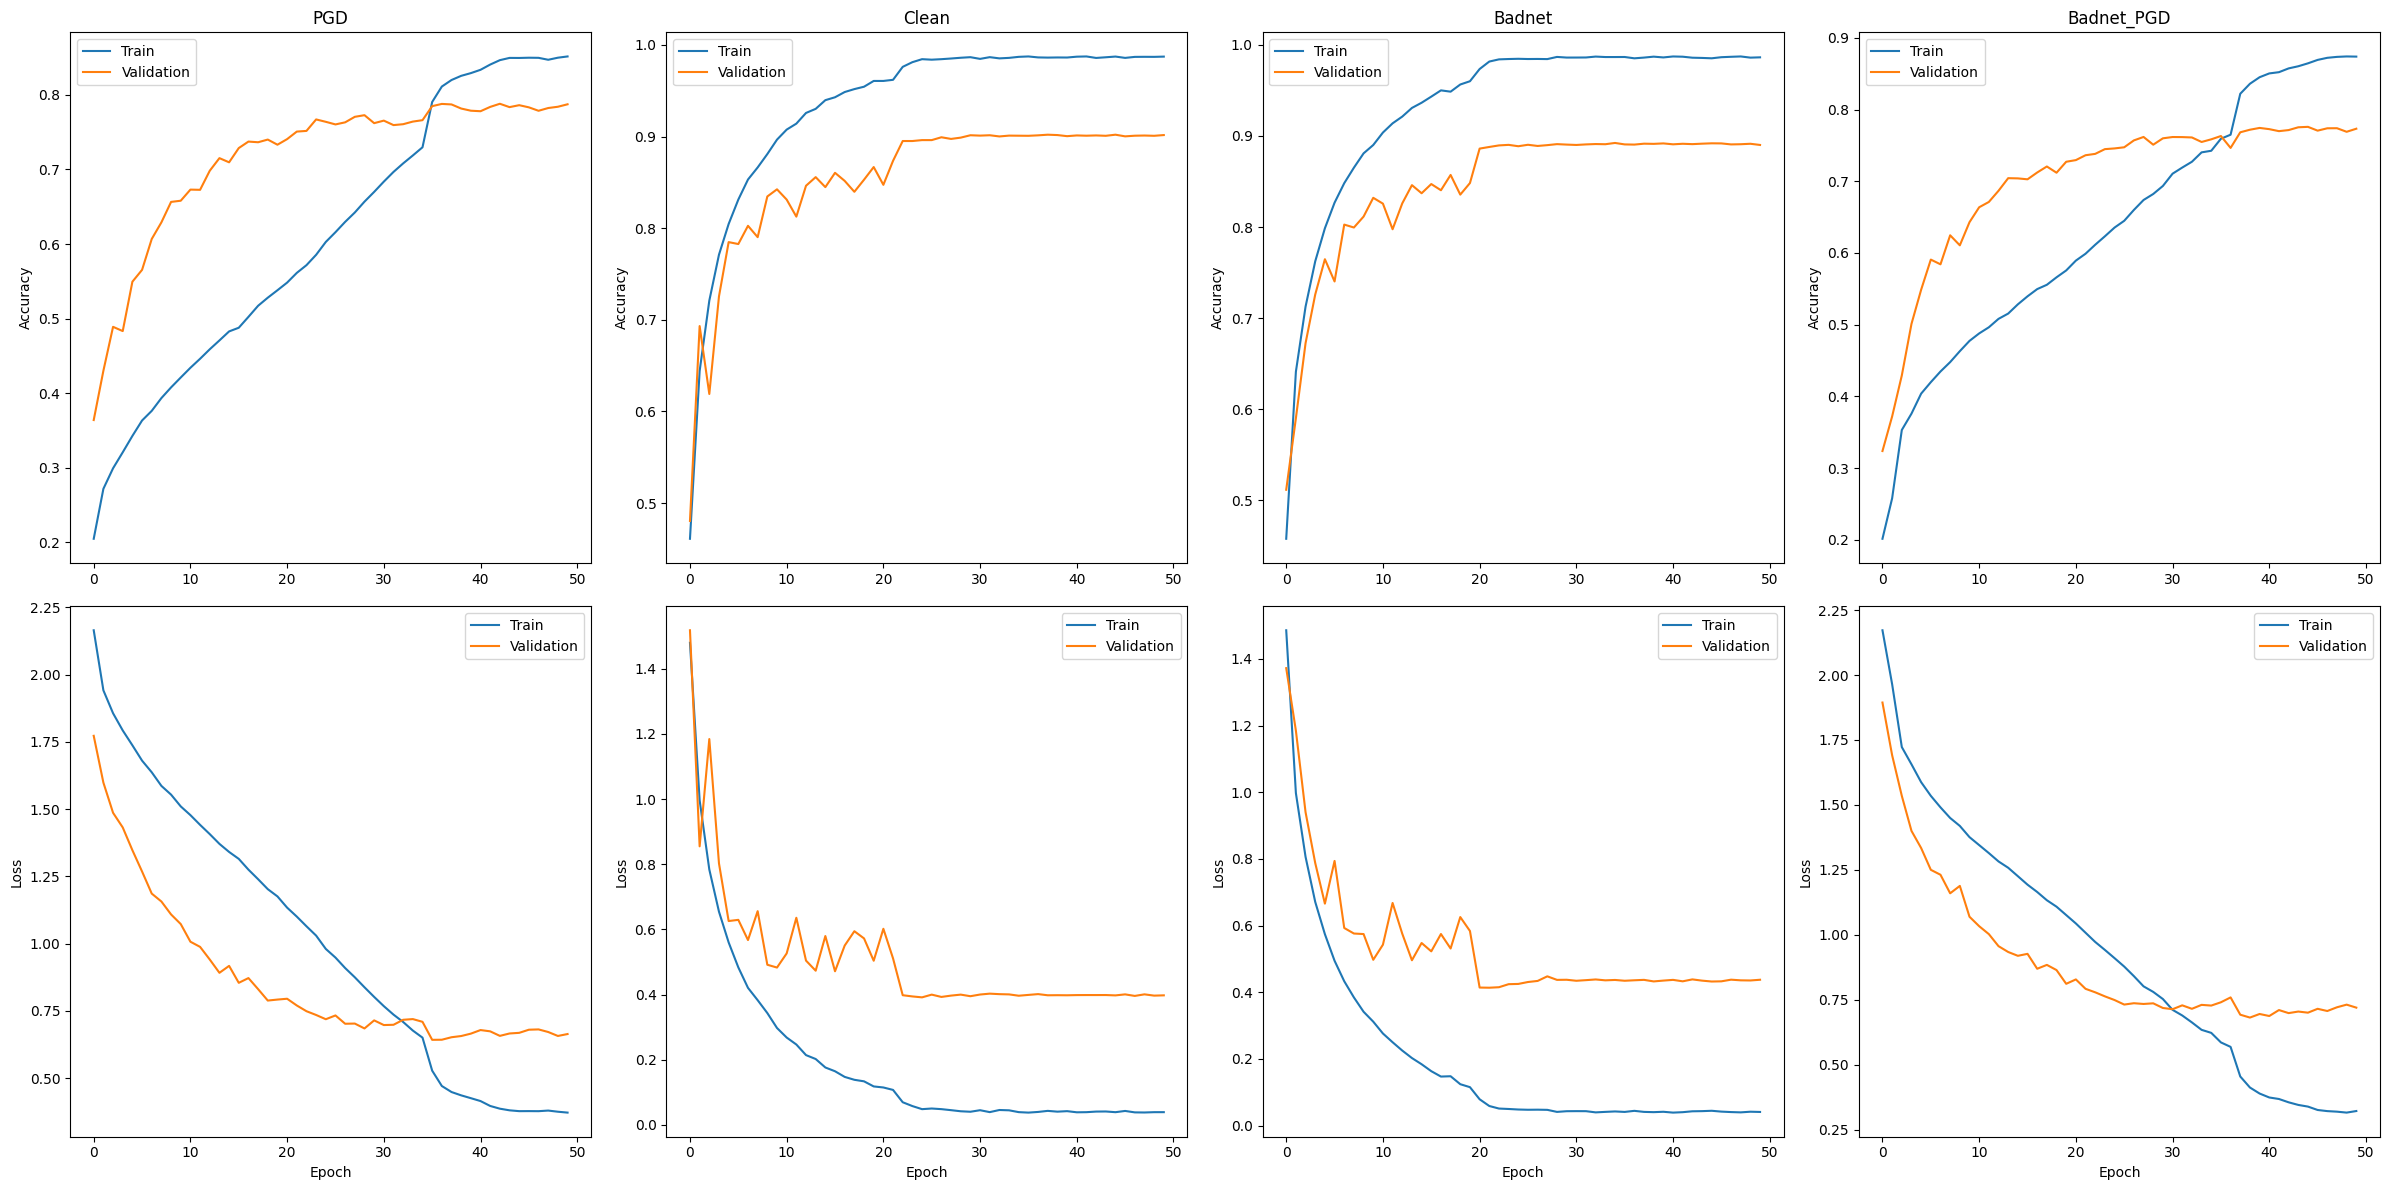

In [81]:

fig, axes = plt.subplots(2, 4, figsize=(24, 12))  
    
for i, (name, dicts) in enumerate(train_method_dict.items()):
    ax1 = axes[0, i]    
    ax1.plot(dicts['acc']['train'], label='Train')
    ax1.plot(dicts['acc']['test'], label='Validation')
    
    ax1.legend()
    ax1.set_ylabel('Accuracy')
    ax1.set_title(name)
    
    ax2 = axes[1, i]
    ax2.plot(dicts['loss']['train'], label='Train')
    ax2.plot(dicts['loss']['test'], label='Validation')
    
    ax2.legend()
    ax2.set_ylabel('Loss')
    ax2.set_xlabel("Epoch")
    
plt.tight_layout()
plt.show()

In [82]:
def load_model(name, device,num_classes, dir='models'):
    states = torch.load(os.path.join(dir, f"{name}.pt"))
    model = resnet18_model(num_classes)
    
    model.load_state_dict(states)
    
    model.to(device)
    
    return model

for name in train_method_dict:
    train_method_dict[name]['model'] = load_model(name.lower(), device, len(classes))

In [94]:

def preds(model , test_loader, pgd, device):
    model.eval()
    Hard_Preds = []
    All_labels = []
    for images, labels in tqdm(test_loader):
        images = pgd_attack(model, images.to(device), labels, device) if pgd else images.to(device)
        labels =  labels.to(device)
        with torch.no_grad():
            preds = model(images)
            
            hard_pred = torch.argmax(preds , dim = 1)
            
            Hard_Preds.append(hard_pred.cpu().numpy())
            All_labels.append(labels.cpu().numpy())

        
    All_labels = np.concatenate( All_labels, axis=0 )
    Hard_Preds = np.concatenate( Hard_Preds, axis=0 )

    return All_labels ,Hard_Preds

In [ ]:
all_eval_sets = {
    "PGD":(test_loader, True),
    "Clean":(test_loader, False),
    "Badnet":(backdoor_test_loader, False),
    "Badnet_PGD":(backdoor_test_loader, True)
}

for name in train_method_dict:
    eval_dict = {}
    
    for eval_name, (data_loader, pgd) in all_eval_sets.items():
        eval_dict[eval_name] = preds(train_method_dict[name]['model'], data_loader, pgd, device)
    
    train_method_dict[name]['eval'] = eval_dict

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

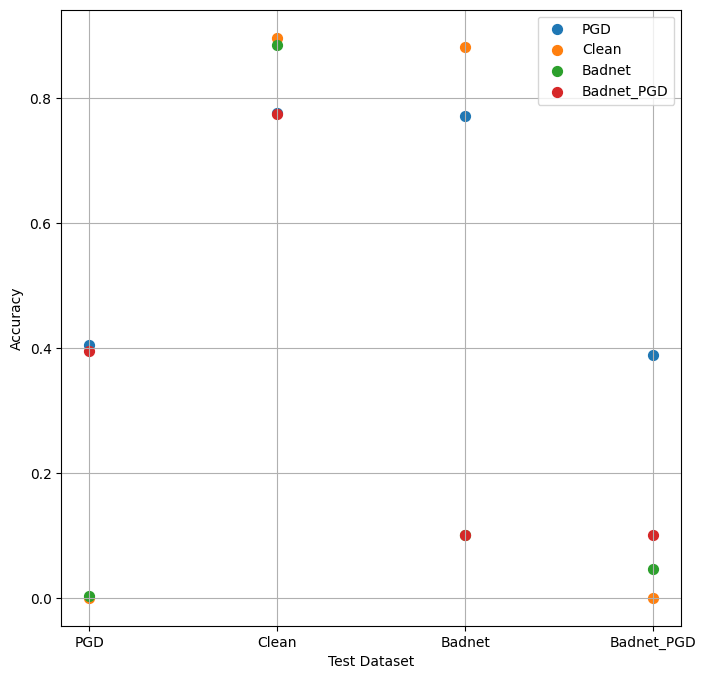

In [142]:
method_names = all_eval_sets.keys()

plt.figure(figsize=(8, 8))

for name, result in train_method_dict.items():
    accuracies = []
    for method_name in method_names:
        accuracies.append(accuracy_score(*result['eval'][method_name]))
    
    plt.scatter(method_names, accuracies, label=name, s= 50)


plt.ylabel("Accuracy")
plt.xlabel("Test Dataset")

plt.grid(True)

plt.legend()
plt.show()
    

In [185]:
def plot_confusion(conf_matrix, classes, ax):
    # Show the matrix as an image
    im = ax.matshow(conf_matrix, cmap='viridis')

    plt.colorbar(im, ax=ax)

    ax.set_xticks(np.arange(conf_matrix.shape[1]))
    ax.set_yticks(np.arange(conf_matrix.shape[0]))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xticklabels(classes, rotation=90)


    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", color="black")

    ax.set_xlabel('Predicted')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')

def plot_4_confusion(method_names, preds_dict, classes, name):

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes = axes.flatten()  
    for i, method_name in enumerate(method_names):
        labels, preds = preds_dict[method_name]
        cm = confusion_matrix(labels, preds)
        plot_confusion(cm, classes, axes[i])
        axes[i].set_title(method_name) 

    plt.suptitle(f"Training on {name} dataset", fontsize=16)

    
    plt.tight_layout()
    plt.show()    


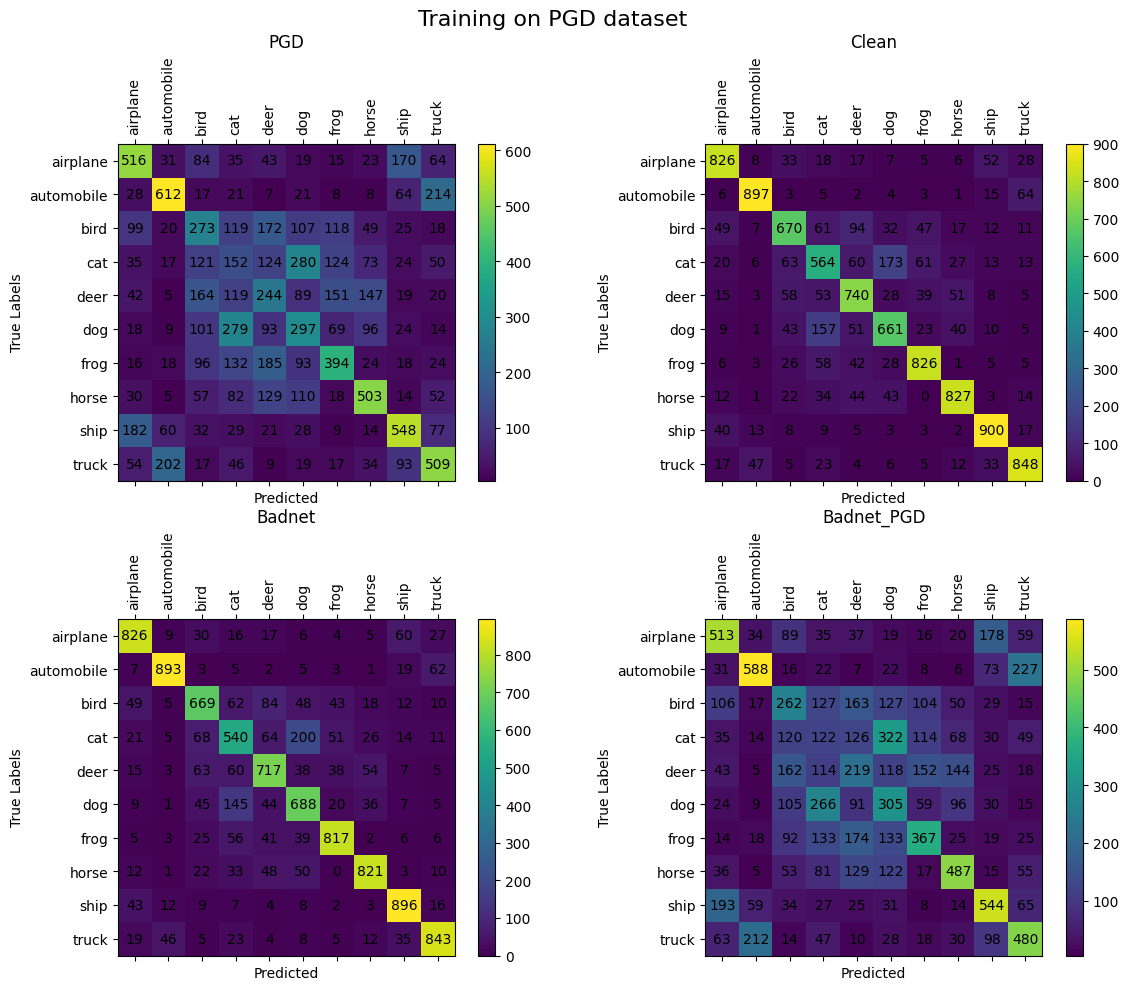

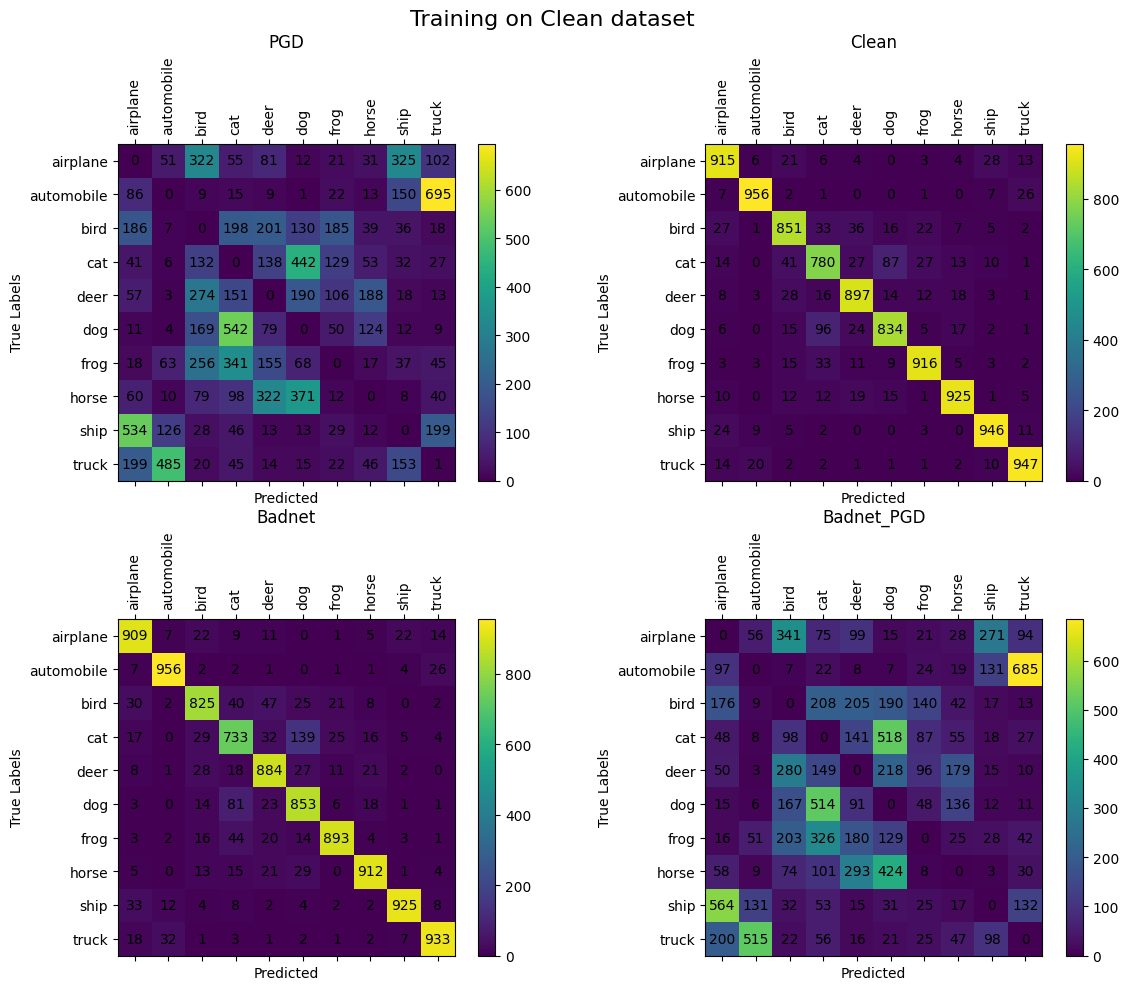

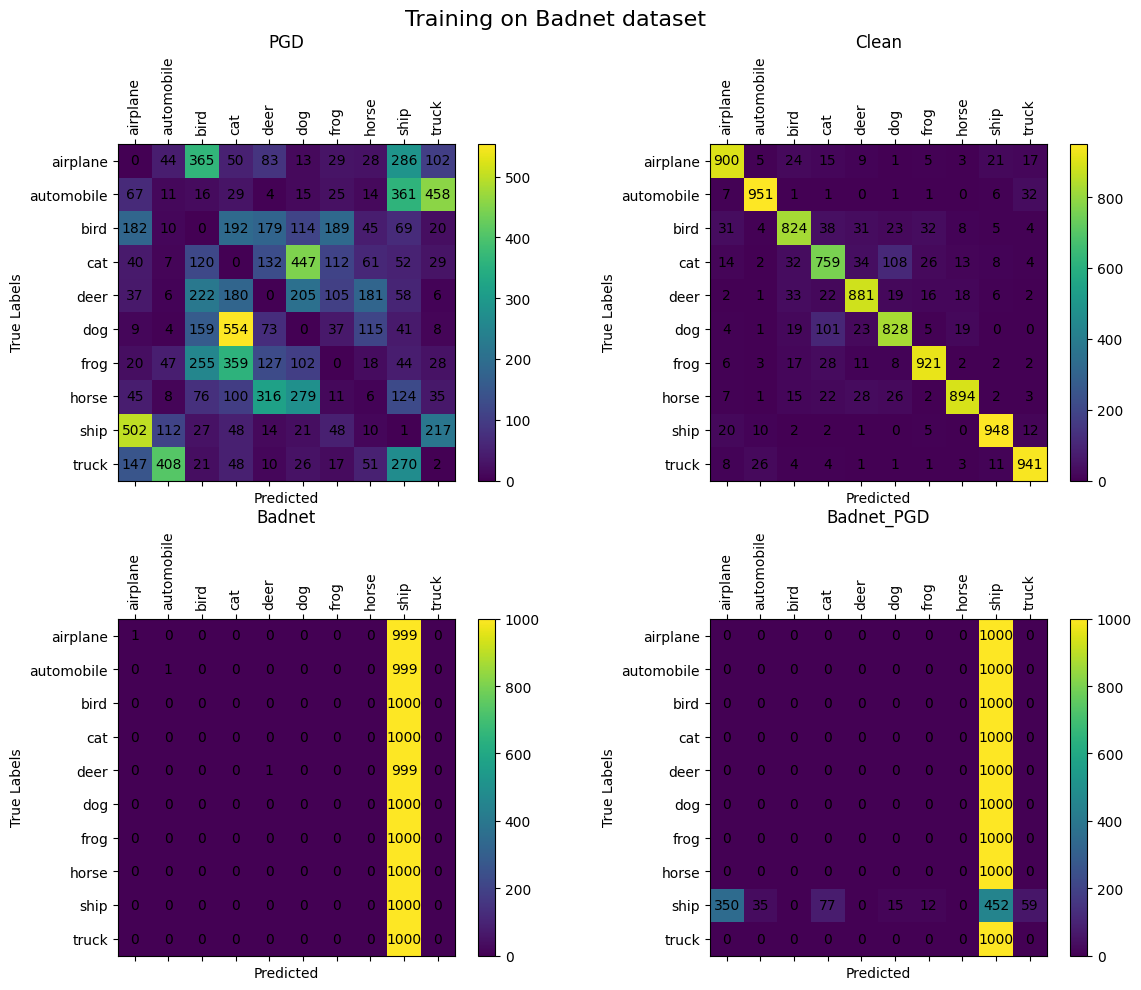

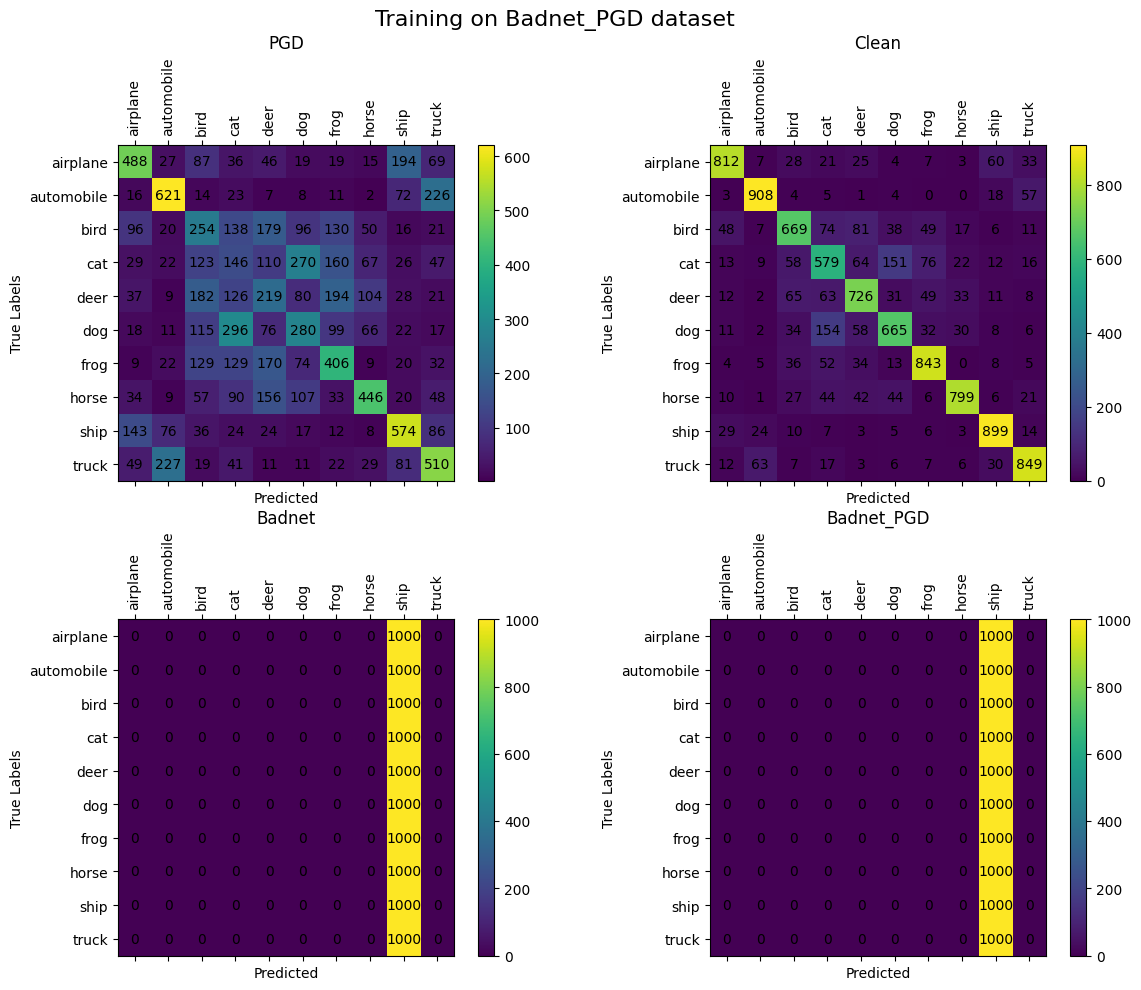

In [184]:
for name in train_method_dict.keys():
    plot_4_confusion(method_names, train_method_dict[name]['eval'], classes, name)
